In [ ]:
import pandas as pd
from utils.pdb import tmscore, pdb_to_npy
import matplotlib.pyplot as plt
import numpy as np
import tqdm
from Bio import pairwise2
from scipy.spatial.transform import Rotation as R
from scipy.stats import pearsonr, spearmanr, kendalltau, linregress

## Paths

In [2]:
PDBS_DIR = './structures'
CODNAS_SAMPLES_DIR = './pretrained_model/codnas.csv.ep7.num5.step0.5.alpha1.0.beta3.0.elbo0.2'
APO_SAMPLES_DIR = './pretrained_model/apo.csv.ep7.num5.step0.5.alpha1.0.beta3.0.elbo0.2'

## Load structures

In [3]:
codnas_df = pd.read_csv('splits/codnas.csv', index_col='name').sort_index()
apo_df = pd.read_csv('splits/apo.csv', index_col='name').sort_index()

In [4]:
codnas_csv = pd.read_csv(CODNAS_SAMPLES_DIR + '.csv');
codnas_csv['name'] = [path.split('/')[-1] for path in codnas_csv.path]; codnas_csv = codnas_csv.set_index('name')
apo_csv = pd.read_csv(APO_SAMPLES_DIR + '.csv');
apo_csv['name'] = [path.split('/')[-1] for path in apo_csv.path]; apo_csv = apo_csv.set_index('name')

In [5]:
def get_structures(path1, path2, seq):
    struct1, seq1 = pdb_to_npy(path1)
    align1 = pairwise2.align.globalxx(seq, seq1)[0]
    struct1_fixed = np.ones((len(seq), 3)) * np.nan
    i, j = 0, 0
    for c, d in zip(align1.seqA, align1.seqB):
        if c != '-' and d != '-': struct1_fixed[i] = struct1[j, 0]
        if c != '-': i+=1
        if d != '-': j+=1

    struct2, seq2 = pdb_to_npy(path2)
    align2 = pairwise2.align.globalxx(seq, seq2)[0]
    struct2_fixed = np.ones((len(seq), 3)) * np.nan
    i, j = 0, 0
    for c, d in zip(align2.seqA, align2.seqB):
        if c != '-' and d != '-': struct2_fixed[i] = struct2[j, 0]
        if c != '-': i+=1
        if d != '-': j+=1
    
    struct1 = struct1_fixed - np.nanmean(struct1_fixed, 0)
    struct2 = struct2_fixed - np.nanmean(struct2_fixed, 0)
    mask = ~np.isnan(struct1[:,0]) & ~np.isnan(struct2[:,0])
    
    rot = R.align_vectors(struct1[mask], struct2[mask])[0].as_matrix()
    struct2 = struct2 @ rot.T
    
    return struct1, struct2

## Analyze CODNAS (fold-switching) pairs

In [6]:
def analyze(pairs_df, samples_csv, samples_dir):
    tmpair = []
    tm1max_list = []
    tm2max_list = []
    ensvar_list = []

    rmsd_dict = {}
    rmsf_dict = {}

    for i, (name1, row) in tqdm.tqdm(enumerate(pairs_df.iterrows()), total=len(pairs_df)):
        tm1, tm2 = [], []
        seq = row.seqres
        try: name2 = row.holo
        except: name2 = row.other
        path1 = f'{PDBS_DIR}/{name1[:2]}/{name1}'
        path2 = f'{PDBS_DIR}/{name2[:2]}/{name2}'

        subdf = samples_csv[samples_csv.index == name1]
        ensvar = []

        struct1, struct2 = get_structures(path1, path2, seq)
        rmsd_dict[name1] = np.square(struct1-struct2).sum(-1)**0.5
        rmsf_dict[name1] = []

        for j in range(len(subdf)):
            path3 = f"{samples_dir}/{name1}.{j}.pdb"
            res = tmscore(path1, path3, lddt=False)
            tm1.append(res['tm'])
            res = tmscore(path2, path3, lddt=False)
            tm2.append(res['tm'])

            for k in range(j+1, len(subdf)):
                path4 = f"{samples_dir}/{name1}.{k}.pdb"
                res = tmscore(path4, path3, lddt=False)
                ensvar.append(res['tm'])
                struct1, struct2 = get_structures(path3, path4, seq)
                rmsf_dict[name1].append(np.square(struct1-struct2).sum(-1)**0.5)

        rmsf_dict[name1] = np.mean(np.stack(rmsf_dict[name1])**2, 0)**0.5

        ensvar_list.append(np.mean(ensvar))

        tm1 = np.array(tm1); tm2 = np.array(tm2)
        tm1max_list.append(tm1.max()); tm2max_list.append(tm2.max())
        res = tmscore(path1, path2, lddt=False)
        vline = res['tm']

        res = tmscore(path2, path1, lddt=False)
        hline = res['tm']

        tmpair.append((hline+vline)/2)
    pairs_df['tm1max'] = tm1max_list
    pairs_df['tm2max'] = tm2max_list
    pairs_df['ensvar'] = ensvar_list
    pairs_df['tmpair'] = tmpair

    return rmsd_dict, rmsf_dict

In [7]:
rmsd_dict, rmsf_dict = analyze(codnas_df, codnas_csv, CODNAS_SAMPLES_DIR)

100%|████████████████████████████████████████████████████████| 77/77 [02:31<00:00,  1.97s/it]


In [8]:
def getmask(name):
    return ~np.isnan(rmsd_dict[name]) & ~np.isnan(rmsf_dict[name])

correls = {name: {
        'pearson': pearsonr(rmsd_dict[name][getmask(name)], rmsf_dict[name][getmask(name)])[0],
        'spearman': spearmanr(rmsd_dict[name][getmask(name)], rmsf_dict[name][getmask(name)]).correlation,
        'kendall': kendalltau(rmsd_dict[name][getmask(name)], rmsf_dict[name][getmask(name)]).correlation
    } for name in codnas_df.index}
codnas_df = codnas_df.join(pd.DataFrame(correls).T)

global_rmsd = np.concatenate(list(rmsd_dict.values()))
global_rmsf = np.concatenate(list(rmsf_dict.values()))
mask = ~np.isnan(global_rmsd) & ~np.isnan(global_rmsd)

In [9]:
print('TM correlation', round(pearsonr(codnas_df.ensvar, codnas_df.tmpair)[0], 2))
print('RMSD global correlation', round(pearsonr(global_rmsd[mask], global_rmsf[mask])[0], 2))
print('RMSD per-target mean', round(codnas_df.pearson.mean(), 2), 'median', round(codnas_df.pearson.median(), 2))

TM correlation 0.36
RMSD global correlation 0.23
RMSD per-target mean 0.28 median 0.26


## Analyze apo/holo pairs

In [10]:
rmsd_dict, rmsf_dict = analyze(apo_df, apo_csv, APO_SAMPLES_DIR)

100%|████████████████████████████████████████████████████████| 90/90 [02:27<00:00,  1.64s/it]


In [11]:
def getmask(name):
    return ~np.isnan(rmsd_dict[name]) & ~np.isnan(rmsf_dict[name])

correls = {name: {
        'pearson': pearsonr(rmsd_dict[name][getmask(name)], rmsf_dict[name][getmask(name)])[0],
        'spearman': spearmanr(rmsd_dict[name][getmask(name)], rmsf_dict[name][getmask(name)]).correlation,
        'kendall': kendalltau(rmsd_dict[name][getmask(name)], rmsf_dict[name][getmask(name)]).correlation
    } for name in apo_df.index}
apo_df = apo_df.join(pd.DataFrame(correls).T)

global_rmsd = np.concatenate(list(rmsd_dict.values()))
global_rmsf = np.concatenate(list(rmsf_dict.values()))
mask = ~np.isnan(global_rmsd) & ~np.isnan(global_rmsd)

In [12]:
print('TM correlation', round(pearsonr(apo_df.ensvar, apo_df.tmpair)[0], 2))
print('RMSD global correlation', round(pearsonr(global_rmsd[mask], global_rmsf[mask])[0], 2))
print('RMSD per-target mean', round(apo_df.pearson.mean(), 2), 'median', round(apo_df.pearson.median(), 2))

TM correlation 0.12
RMSD global correlation 0.13
RMSD per-target mean 0.41 median 0.4


## Plots

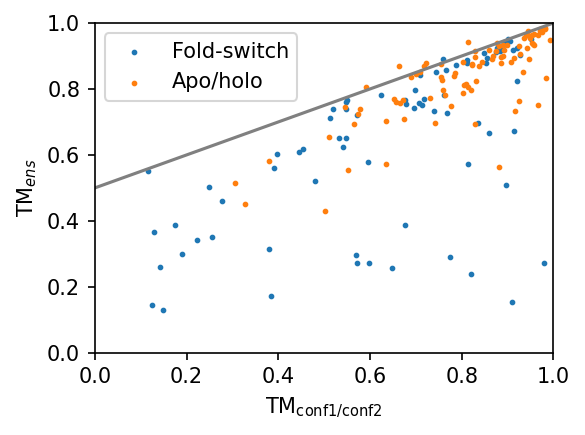

In [13]:
plt.figure(figsize=(4,3), dpi=150)
plt.scatter(codnas_df.tmpair, (codnas_df.tm1max+codnas_df.tm2max)/2, s=3, label='Fold-switch')
plt.scatter(apo_df.tmpair, (apo_df.tm1max+apo_df.tm2max)/2, s=3, label='Apo/holo')
plt.xlim(0, 1); plt.ylim(0, 1); plt.legend()
plt.xlabel('TM$_\mathregular{conf1/conf 2}$')
plt.ylabel('TM$_{ens}$')
plt.plot((0,1),(0.5,1), c='gray')
plt.tight_layout()

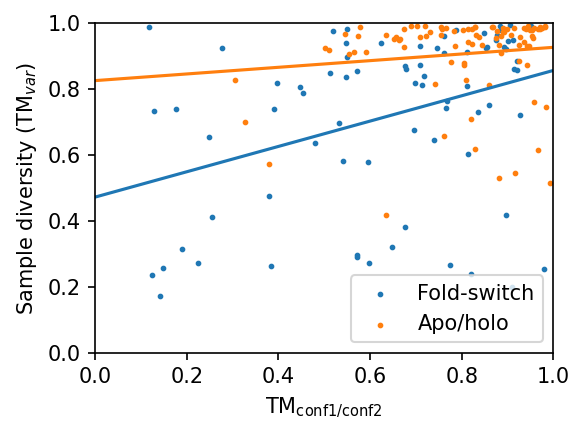

In [14]:
plt.figure(figsize=(4,3), dpi=150)
plt.scatter(codnas_df.tmpair, codnas_df.ensvar, s=3, label='Fold-switch')
plt.scatter(apo_df.tmpair, apo_df.ensvar, s=3, label='Apo/holo')
plt.xlim(0, 1); plt.ylim(0, 1);
plt.xlabel('TM$_\mathregular{conf1/conf 2}$')
plt.ylabel('Sample diversity (TM$_{var}$)')
reg = linregress(codnas_df.tmpair, codnas_df.ensvar)
plt.plot((0, 1), (reg.intercept, reg.slope+reg.intercept))
reg = linregress(apo_df.tmpair, apo_df.ensvar)
plt.plot((0, 1), (reg.intercept, reg.slope+reg.intercept))
plt.legend(loc='lower right')
plt.tight_layout()